#### Clustering seeds varieties
Learning how to choose a good number of clusters can be tricky! In this anlaysis I'll show how unsupervised data can be clustered relatively easily using data from the University of California, Irvine on various types of [seeds](https://archive.ics.uci.edu/ml/datasets/seeds#). The seeds data is a collection of measurements of geometrical properties of kernels belonging to three different varieties of wheat.

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [201]:
# Create a list of column names
cols = ['Area', 'Perimeter','Compactness','Kernel_Length','Kernel_Width','Assymetry_Coefficient','Kernel_Groove_Length', 'Class']

# Read in the seed varieties csv into a dataframe
seeds_df = pd.read_csv('datasets/seeds.csv', names=cols)
seeds_df.head()


,Area,Perimeter,Compactness,Kernel_Length,Kernel_Width,Assymetry_Coefficient,Kernel_Groove_Length,Class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


#### Find the ideal number of clusters
Using a k-means inertia graph I'll demonstrate how to find the ideal number of clusters. 

A good clustering has tight clusters. Meaning the samples in the cluster are bunched together and not spread out. Interia measure just how spread out the samples in the data are. Specifically, interia measures the distance between a given sample and it's centroid (middle of the cluster). The lower the interia the better the clustering. However, there is a trade-off when selecting a high value of clusters, namely a good clustering should also have relatively few clusters. A good rule of thumb is to use the pivot (or elbow) of the inertia graph––after which choosing a high number of clusters yields diminishing returns on low inertia. We'll see that in the below graph:

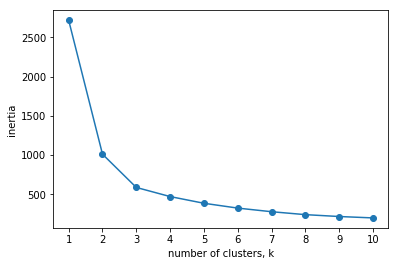

In [191]:
# Create an array which excludes the binary class column.
samples_all = seeds_df.drop('Class', axis=1).values

# Create a range of values to serve as possible clusters.
ks = range(1, 11)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(samples_all)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

#### Evaluating the grain clustering
The inertia plot above shows that after 3 clusters the line begins to flattern out. This means choosing more than 3 clusters doesn't yield a great deal in lower inertia. As such 3 is the ideal number of clusters. 

Now I'll cluster the grain samples into 3 clusters, and using cross-tablulation I'll compare the clusters to the grain varieties. The cross tabulation seen below shows each of the seed varieties across the top, Canadian, Kama, and Rosa wheat, and one row for each of the 3 clusters we specfied based on the interia graph––0, 1, and 2. A cross tablution effectively shows how well our chosen clusters fit into the given seed varieties. As you can see, some seeds are labeled incorrectly, but by in large most seeds are labeled into their respective seed variety.

In [193]:
# Read in the seed varieties csv and transform the values into a list
varieties_df = pd.read_csv('datasets/varieties_all.csv', names=['variety'], index_col=False)
varieties_all = varieties_df.variety.tolist()

# Create a KMeans model with 3 clusters
model = KMeans(n_clusters=3)

# Use fit_predict to fit model and obtain cluster labels
labels = model.fit_predict(samples_all)

# Create a DataFrame with labels and varieties as columns
df = pd.DataFrame({'labels': labels, 'varieties': varieties_all})

# Create crosstab
ct = pd.crosstab(df['labels'], df['varieties'])

# Display ct
print(ct)

varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
0                       0           1          60
1                      68           9           0
2                       2          60          10


#### Extracting the cluster labels
Now, I'll use the `fcluster()` function to extract the cluster labels for an intermediate clustering (mergings and varieties), and compare the labels with the grain varieties using a cross-tabulation.

In [194]:
# Perform the necessary imports
from scipy.cluster.hierarchy import fcluster

# Use fcluster to extract labels
labels = fcluster(mergings, 6, criterion='distance')

# Create a DataFrame with labels and varieties as columns
df = pd.DataFrame({'labels': labels, 'varieties': varieties})

# Create crosstabulation
ct = pd.crosstab(df['labels'], df['varieties'])

# Display ct
print(ct)

varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
1                      14           3           0
2                       0           0          14
3                       0          11           0


#### Cross Tabulation Conclusion and TSNE
The cross tabulation seen above shows each of the seed varieties across the top, Canadian, Kama, and Rosa wheat, and one row for each of the 3 clusters––1, 2, & 3. This intermediate cross tablution more effectively shows the correspondence between the clusters and the seed varieties. As you can see now, label 2 (or cluster 2) corresponds perfectly with the species Rosa wheat, while label 3 corresponds perfectly with Kama wheat. By process of elimination we can say that Label 1 corresponds with Canadian wheat--which is indeed the correct label--though we do see that the model erroneously estimates some Kama wheat seeds.

t-SNE or t-distributed stochastic neihbor embedding has a simple purpose. It maps samples from their higher dimensional space (all the features) to 2D or 3D spaces for visualization. While some distortion is inevitable, t-SNE does a great job of approximately representing the distances between samples.

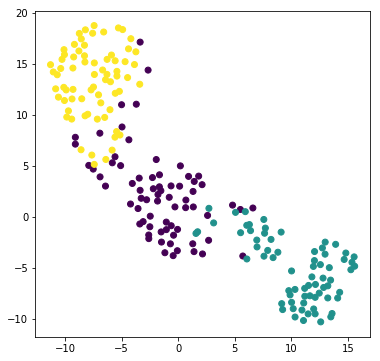

In [202]:
# Import TSNE
from sklearn.manifold import TSNE

# Transform the Class column into a list of it's values
variety_numbers = seeds_df.Class.tolist()

# Create a TSNE instance where learning rates can be between 1-200 generally
model = TSNE(learning_rate=200)

# Apply fit_transform to samples, note tsne only has a fit_transform method
tsne_features = model.fit_transform(samples_all)

# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot, coloring by variety_numbers
plt.figure(figsize=(6,6))
plt.scatter(xs, ys, c=variety_numbers)
plt.show()

#### Dimension Reduction
Dimension reduction finds patterns in data and uses these patterns to re-express the data in compressed form. This makes subsequent computation of the data much more efficient. The most important aspect of dimension reduction is to reduce a data set to it's barebones, removing noisey, uninformative features thereby making additional analysis less problematic. In many real world applications it's dimension reduction that makes good prediction possible.

I'll try out PCA or Principle Component Analysis on the seeds data, where the fist step is decorrelating the data using the Pearson R correlation. But first, given the array of grains with the width and length of samples of grain, it may be possible that these two features are correlated to each other, eg. what's wide is also long. I can confirm this by making a scatter plot of width vs length and measure their Pearson correlation.

Following, I'll decorrelate the data and then reduce the dimensionality of the data using the `PCA()` function.

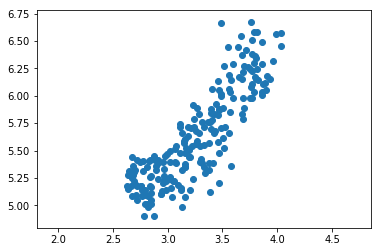

0.8604149377143467


In [203]:
# Perform the necessary imports
from scipy.stats import pearsonr

grains = seeds_df[['Kernel_Width', 'Kernel_Length']].values

# Assign the 0th column of grains
width = grains[:,0]

# Assign the 1st column of grains
length = grains[:,1]

# Scatter plot width vs length
plt.scatter(width, length)
plt.axis('equal')
plt.show()

# Calculate the Pearson correlation
correlation, pvalue = pearsonr(width, length)

# Display the correlation
print(correlation)

#### PCA
You can see above that the width and length measurements of the seeds data are indeed correlated. Now, I'll use PCA to decorrelate these measurements, plot the decorrelated points, and measure their Pearson correlation. PCA rotates the data to be aligned with the axes effectively shifting the data samples so their mean is 0. Because of this no data is actually lost no matter how many features you may be working with. PCA is called Princepal Componenet Analysis precisely because it learns the principle components of the data--these are the directions of which the samples vary the most.

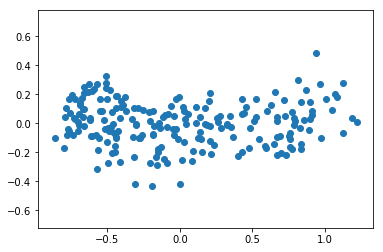

7.474656899453042e-17
1.0


In [204]:
# Import PCA
from sklearn.decomposition import PCA

# Create PCA instance
model = PCA()

# Apply the fit_transform method of model to grains
pca_features = model.fit_transform(grains)

# Assign 0th column of pca_features
xs = pca_features[:,0]

# Assign 1st column of pca_features
ys = pca_features[:,1]

# Scatter plot xs vs ys
plt.scatter(xs, ys)
plt.axis('equal')
plt.show()

# Calculate the Pearson correlation of xs and ys
correlation, pvalue = pearsonr(xs, ys)

# Display the correlation
print(correlation)
print(pvalue)

#### Intrinsic Dimension
The intrinsic dimensions of a data set are the number of features required to approximate it. It also informs dimension reduction because it tells us how much a data set can be compressed. I'll use PCA again to get a solid understanding of the intrinsic dimensions of the seeds data set, by counting the number of PCA features that have a high variance.

First, I'll use PCA to find the first principal component of the length and width measurements of the grain samples, and represent it as an arrow on the scatter plot. Finally, I'll plot the intrinsic features as a bar graph to visualize how many of the features are significant.

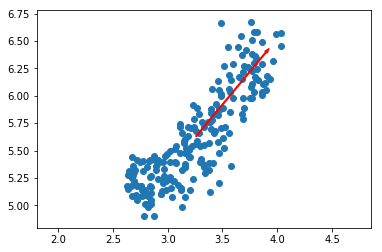

In [205]:
# Make a scatter plot of the untransformed points
plt.scatter(grains[:,0], grains[:,1])

# Create a PCA instance
model = PCA()

# Fit model to points
model.fit(grains)

# Get the mean of the grain samples
mean = model.mean_

# Get the first principal component
first_pc = model.components_[0,:]

# Plot first_pc as an arrow, starting at mean
plt.arrow(mean[0], mean[1], first_pc[0], first_pc[1], color='red', width=0.01)

# Keep axes on same scale
plt.axis('equal')
plt.show()

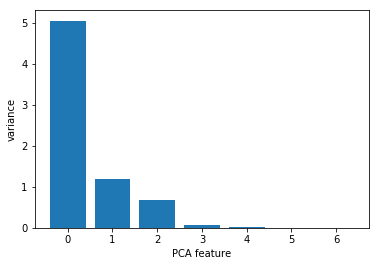

In [206]:
# Perform the necessary imports
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler
scaler = StandardScaler()

# Create a PCA instance
pca = PCA()

# Create pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to 'samples'
pipeline.fit(samples_all)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

#### Variance of the PCA features
The seeds data is 7 dimensional, meaning it has 7 features, and of those dimensions (or features) only 2 have a variance higher than 1. Therefore we can reasonably say that this data set has 2 intrinsic dimensions. However, you wouldn't be wrong to assert that there are 3 intrinsic dimension given the 3rd feature has relatively high variance in comparision to the remaining features.

In [207]:
# Create scaler
scaler = StandardScaler()

# Create a PCA model with 2 components
pca = PCA(n_components=3)

# Create pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the PCA instance to the scaled samples
pipeline.fit(samples_all)

# Transform the scaled samples
pca_features = pca.transform(samples_all)

# Print the shape of pca_features
print(pca_features.shape)

(210, 3)


#### Conclusion Dimension Reduction with PCA
Finally, I've performed the dimension reduction of the seed data set using PCA and specifying the number of `n_components` (3) to keep--the number of intrinsic dimension. Dimension reduction represents the same data with less features. Winning!